## 인코딩 방법 정리
### 원핫인코딩 (One-Hot Encoding)
- 원핫인코딩은 범주형 데이터를 수치형 데이터로 변환하는 방법입니다. 각 범주를 새로운 열로 나타내며, 해당 범주에 속하면 1, 속하지 않으면 0의 값을 가집니다.
```python
encoded_df = pd.get_dummies(df, columns=['CategoricalColumn'])
```
### 레이블인코딩 (Label Encoding)
레이블인코딩은 범주형 데이터를 순차적인 숫자로 변환하는 방법입니다. 주의해야 할 점은 숫자의 크기에 의미가 없는 경우에는 사용하지 않는 것이 좋습니다.
```python
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['CategoricalColumn'] = label_encoder.fit_transform(df['CategoricalColumn'])
```
### 순서인코딩 (Ordinal Encoding)
순서인코딩은 범주형 데이터를 순서를 고려하여 숫자로 변환하는 방법입니다. 범주 간의 순서가 중요한 경우에 사용됩니다.
```python
order_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
df['CategoricalColumn'] = df['CategoricalColumn'].map(order_mapping)
```
### 타겟인코딩 (Target Encoding)
타겟인코딩은 범주형 데이터를 해당 범주에 대한 타겟 변수의 평균 또는 다른 통계량으로 변환하는 방법입니다. 주로 회귀 문제에서 사용되며, 특정 범주의 타겟 변수 값을 대체하여 모델에 입력합니다.
```python
target_mapping = df.groupby('CategoricalColumn')['TargetColumn'].mean().to_dict()
df['CategoricalColumn'] = df['CategoricalColumn'].map(target_mapping)
```

## 데이터 클리닝
### 1. 결측치 처리
- `df.isnull().sum()` # 결측치 개수 확인
- `df.dropna()` # 결측치가 있는 행 제거
- `df.fillna(0)` # 결측치를 0으로 대체
- `df.fillna(df['Age'].mean(), inplace=True)` # 결측치를 평균값으로 대체
- `df.fillna(df['Age'].median(), inplace=True)` # 결측치를 중앙값으로 대체
- `df.fillna(df['Age'].mode()[0], inplace=True)` # 결측치를 최빈값으로 대체
- `df['Age'] = df['Age'].fillna(df.groupby('Name')['Age'].transform('median'))` # 결측치를 그룹별 중앙값으로 대체(Name 컬럼을 기준으로 그룹화한 후, 그룹별 중앙값으로 대체)
- `df['Age'].fillna(method='ffill', inplace=True)` # 결측치를 앞의 값으로 대체
- `df['Age'].fillna(method='bfill', inplace=True)` # 결측치를 뒤의 값으로 대체
- `df.interpolate(method='linear', inplace=True)` # 결측치를 선형으로 대체, 시계열 데이터에 적합
- `df.interpolate(method='polynomial', order=2, inplace=True)` # 결측치를 2차 함수로 대체, 시계열 데이터에 적합
- `df.interpolate(method='spline', order=2, inplace=True)` # 결측치를 2차 스플라인으로 대체, 시계열 데이터에 적합
- `df.interpolate(method='krogh', inplace=True)` # 결측치를 Krogh 방법으로 대체, 시계열 데이터에 적합(Krogh는 곡선을 생성하지만 고차원 다항식을 생성하지 않아 과적합을 방지할 수 있음)
- `df.interpolate(method='piecewise_polynomial', order=2, inplace=True)` # 결측치를 2차 다항식으로 대체, 시계열 데이터에 적합
## 다중 대치법
```python
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(max_iter=10, random_state=0, initial_strategy='median', tol=0.001, n_nearest_features=4)
# initial_strategy: 결측치를 대체할 초기값을 설정합니다. 'mean', 'median', 'most_frequent' 중 하나를 선택할 수 있습니다.
# tol: 결측치 대체가 수렴하는 기준을 설정합니다.
# n_nearest_features: 결측치 대체에 사용할 특성의 개수를 설정합니다. (default=None: 모든 특성 사용)

imputed_data = imputer.fit_transform(train[['Column1', 'Column2', 'Column3', 'Column4', 'Column5']])
# Column1 ~ Column5까지의 변수를 이용해 결측치를 다중대체법으로 대체
train['Column1'] = imputed_data[:, 0]
# Column1의 결측치를 다중대체법으로 대체한 값으로 대체, [:,0]으로 imputed_data의 첫 번째 컬럼을 Column1에 대입

# 모든 변수를 이용해 결측치를 다중대체법으로 대체 (이 때, 범주형 변수의 경우 인코딩을 먼저 수행해야 함)
train = pd.DataFrame(imputer.fit_transform(train), columns=train.columns)
```

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [21]:
df = pd.read_csv('train.csv')

In [22]:
imputer = IterativeImputer(max_iter=10, initial_strategy='median', tol=0.001, n_nearest_features=4)
imputed_data = imputer.fit_transform(df[['LotFrontage', 'SalePrice','OverallCond','OverallQual']])

In [24]:
df['LotFrontage'] = imputed_data[:,0]

### 2. 이상치 처리
#### IQR(Interquartile Range, 사분범위) 기반 이상치 처리 (Tukey's Fences)
- `df.describe()` # 기술통계량 확인
- `sns.boxplot(x=df['Column'], y=df['TargetColumn'], fliersize=2.5, whis=1.5)` # 상자그림으로 이상치 확인
```python
#fliersize: 이상치 마커의 크기, whis: 이상치 경계값(기본값 1.5;1.5*IQR)
```
- `Q1 = df['Column'].quantile(0.25)` # 1사분위수
- `Q3 = df['Column'].quantile(0.75)` # 3사분위수
- `IQR = Q3 - Q1` # IQR(Interquartile Range, 사분범위)
- `lower_bound = Q1 - 1.5 * IQR` # 하한값
- `upper_bound = Q3 + 1.5 * IQR` # 상한값
- `df = df[(df['Column'] >= lower_bound) & (df['Column'] <= upper_bound)]` # 이상치 제거
#### Z-Score 기반 이상치 처리
- `from scipy import stats`
- `z_scores = np.abs(stats.zscore(df['Column']))` # Z-Score 계산
- `threshold = 3` # 임계값 설정
- `df = df[(z_scores < threshold)]` # 이상치 제거
#### DBSCAN 기반 이상치 처리
- `from sklearn.cluster import DBSCAN`
- `outlier_detection = DBSCAN(min_samples=2, eps=3)` # eps: 이웃을 정의하는 거리, min_samples: 핵심 샘플의 최소 개수
- `clusters = outlier_detection.fit_predict(df)` # 이상치를 제외한 모든 샘플의 클러스터 레이블을 반환
- `df = df[clusters != -1]` # 이상치 제거
#### Isolation Forest 기반 이상치 처리 (다변량 이상치 탐지)
- `from sklearn.ensemble import IsolationForest`
- `outlier_detection = IsolationForest(contamination=0.01)` # contamination: 이상치 비율
- `clusters = outlier_detection.fit_predict(df)` # 이상치를 제외한 모든 샘플의 클러스터 레이블을 반환
- `df = df[clusters != -1]` # 이상치 제거
#### Local Outlier Factor 기반 이상치 처리
- `from sklearn.neighbors import LocalOutlierFactor`
- `outlier_detection = LocalOutlierFactor(n_neighbors=2, contamination=0.01)` # n_neighbors: 이웃의 개수, contamination: 이상치 비율
- `clusters = outlier_detection.fit_predict(df)` # 이상치를 제외한 모든 샘플의 클러스터 레이블을 반환
- `df = df[clusters != -1]` # 이상치 제거
```python
# 이상치 제거 예시
from sklearn.ensemble import IsolationForest
outlier_detection = IsolationForest(max_samples = 100, contamination = 0.02, random_state = 12, n_neighbors = 10)
clusters = outlier_detection.fit_predict(train[['LotFrontage', 'LotArea']]) # 연속형 변수만 사용, 결과는 numpy.ndarray, -1은 이상치 1은 정상치
clusters=pd.Series(clusters)
train=pd.concat([train, clusters], axis=1).rename(columns={0:'outlier'})
train = train[train['outlier']!=-1]
```

In [26]:
import pandas as pd

In [43]:
df = pd.read_csv('train.csv')
df.dropna(axis=0, subset=['LotFrontage'], inplace=True)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [44]:
from sklearn.ensemble import IsolationForest

outlier_detection = IsolationForest(max_samples = 100, contamination = 0.02, random_state = 12)
clusters = outlier_detection.fit_predict(df[['LotFrontage', 'LotArea']])
print(clusters)

[1 1 1 ... 1 1 1]


In [45]:
df['outlier'] = clusters
df = df[df['outlier'] != -1]
df.drop(['outlier'], axis=1, inplace=True)

### 3. 중복 데이터 처리
- `df.duplicated().sum()` # 중복 데이터 개수 확인
- `df.drop_duplicates(inplace=True)` # 중복 데이터 제거

### 4. 클래스 불균형 처리
- 데이터를 변경하는 것이 아니라, 데이터를 생성하는 방식으로 불균형을 처리함
##### 4-1. 언더샘플링
- `from imblearn.under_sampling import RandomUnderSampler`
- `rus = RandomUnderSampler()` # RandomUnderSampler 객체 생성
- `X_rus, y_rus = rus.fit_resample(X, y)` # 언더샘플링 수행
##### 4-2. 오버샘플링
- `from imblearn.over_sampling import RandomOverSampler`
- `ros = RandomOverSampler()` # RandomOverSampler 객체 생성
- `X_ros, y_ros = ros.fit_resample(X, y)` # 오버샘플링 수행
##### 4-3. SMOTE
- `from imblearn.over_sampling import SMOTE`
- `smote = SMOTE(sampling_strategy='auto', k_neighbors=5)` # SMOTE 객체 생성, sampling_strategy: 샘플링 전략(기본값 auto, minority, not minority, all, not majority)
- `X_smote, y_smote = smote.fit_resample(X, y)` # SMOTE 수행
##### 4-3-1. Borderline-SMOTE
- `from imblearn.over_sampling import BorderlineSMOTE`
- `bsmote = BorderlineSMOTE(sampling_strategy='auto', k_neighbors=5)` # Borderline-SMOTE 객체 생성
- `X_bsmote, y_bsmote = bsmote.fit_resample(X, y)` # Borderline-SMOTE 수행
##### 4-3-2. K-Means SMOTE
- `from imblearn.over_sampling import KMeansSMOTE`
- `ksmote = KMeansSMOTE(k_neighbors=5)` # K-Means SMOTE 객체 생성
- `X_ksmote, y_ksmote = ksmote.fit_resample(X, y)` # K-Means SMOTE 수행
##### 4-3-3. SVMSMOTE(Support Vector Machine SMOTE)
- `from imblearn.over_sampling import SVMSMOTE`
- `svmote = SVMSMOTE()` # SVMSMOTE 객체 생성
- `X_svmote, y_svmote = svmote.fit_resample(X, y)` # SVMSMOTE 수행
##### 4-4. ADASYN(Adaptive Synthetic Sampling): 가중치를 부여하여 샘플링
- `from imblearn.over_sampling import ADASYN`
- `adasyn = ADASYN()` # ADASYN 객체 생성
- `X_adasyn, y_adasyn = adasyn.fit_resample(X, y)` # ADASYN 수행

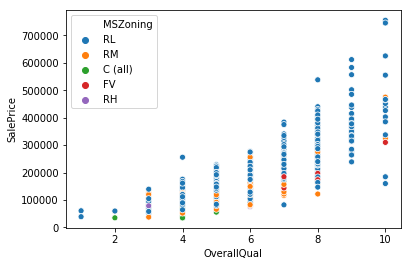

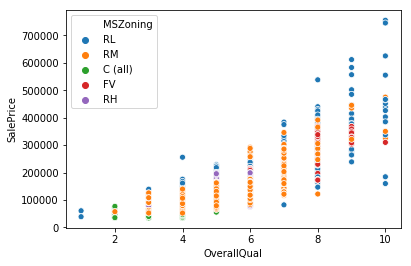

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv('train.csv')
df.dropna(axis=1, inplace=True)
df.describe(include='O')
#MSZoning의불균형 처리
sns.scatterplot(x='OverallQual', y='SalePrice', hue='MSZoning', data=df)
plt.show()

#SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(df[['SalePrice', 'OverallQual', 'OverallCond']], df['MSZoning'])
smote_df = pd.concat([X_smote, y_smote], axis=1)
sns.scatterplot(x='OverallQual', y='SalePrice', hue='MSZoning', data=smote_df)
plt.show()

## 5. 특성 공학
- `df['NewColumn'] = df['Column1'] +-*/ df['Column2']` # 새로운 특성 생성
- `df['NewColumn'] = df['Column1'] ** df['Column2']` # 새로운 특성 생성
- `df['NewColumn'] = df['Column1'] % df['Column2']` # 새로운 특성 생성
- `df['NewColumn'] = df['Column1'].apply(lambda x: x**2)` # 새로운 특성 생성
- `df['NewColumn'] = df['Column1'].apply(lambda x: x**0.5)` # 새로운 특성 생성
- `df['NewColumn'] = df['Column1'].apply(lambda x: np.log(x))` # 새로운 특성 생성
- `df['NewColumn'] = df['Column1'].apply(lambda x: np.exp(x))` # 새로운 특성 생성

## 6. 특성 스케일링
#### 표준화, 정규화(Standardization, Normalization)
```python
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer, PowerTransformer

scaler = StandardScaler()
df['Column'] = scaler.fit_transform(df[['Column']])
```
- `StandardScaler`: 평균이 0과 표준편차가 1이 되도록 변환, 공식: (X - X의 평균) / X의 표준편차
- `MinMaxScaler`: 0~1사이의 값으로 변환, 공식: (X - X의 최소값) / (X의 최대값 - X의 최소값)
- `RobustScaler`: 중앙값(median)이 0, IQR(interquartile range)이 1이 되도록 변환, 공식: (X - Q2) / (Q3 - Q1) (이상치 영향 최소화)
- `QuantileTransformer`: 데이터를 정규분포 형태로 변환, 공식: (X - X의 중앙값) / X의 IQR
- `PowerTransformer`: yeojohnson, boxcox 변환을 사용하여 데이터를 정규분포 형태로 변환 (boxcox는 양수 데이터만 변환 가능, yeojohnson은 음수 데이터도 변환 가능)
```python
from sklearn.preprocessing import PowerTransformer

scaler = PowerTransformer(method='yeo-johnson') # yeo-johnson, box-cox
df['Column'] = scaler.fit_transform(df[['Column']])
```

### 7. 특성 선택
#### 상관관계 기반 특성 선택
- `df.corr()` # 상관관계 확인
- `df.corr()['TargetColumn'].sort_values(ascending=False)` # TargetColumn과의 상관관계 확인
- `high_corr = df.corr()['TargetColumn'].sort_values(ascending=False).head(3)` # TargetColumn과의 상관관계가 높은 상위 3개 특성 확인
- `df = df[high_corr.index]` # 상위 3개 특성만 선택
#### Lasso, Ridge 기반 특성 선택
- `from sklearn.linear_model import Lasso, Ridge`
- `lasso = Lasso(alpha=0.01)` # alpha: 규제 정도
- `lasso.fit(X_train, y_train)` # 특성 중요도 계산
- `lasso.coef_` # 특성 중요도 확인
- `df = df[lasso.coef_ != 0]` # 특성 중요도가 0이 아닌 특성만 선택, 혹은 특성 중요도가 상위 3개인 특성만 선택 등...
#### SelectKBest 기반 특성 선택
- `from sklearn.feature_selection import SelectKBest, f_regression`
- `selector = SelectKBest(score_func=f_regression, k=3)` # score_func: 특성 중요도를 계산하는 함수, k: 선택할 특성의 개수
- `selector.fit(X_train, y_train)` # 특성 중요도 계산
- `selector.scores_` # 특성 중요도 확인
#### RFE(Recursive Feature Elimination) 기반 특성 선택
- `from sklearn.feature_selection import RFE`
- `from sklearn.linear_model import LinearRegression`
- `rfe = RFE(estimator=LinearRegression(), n_features_to_select=3)` # n_features_to_select: 선택할 특성의 개수
- `rfe.fit(X_train, y_train)` # 특성 중요도 계산
- `rfe.support_` # 선택된 특성 확인 (True: 선택, False: 선택되지 않음)
- `rfe.ranking_` # 특성 순위 확인 (1: 가장 중요, 2: 두 번째로 중요, ...)
- `df = df[df.columns[rfe.support_]]` # 선택된 특성만 선택
#### 트리 기반 특성 선택
- `from sklearn.ensemble import RandomForestRegressor`
- `rf = RandomForestRegressor(n_estimators=100)` # n_estimators: 트리의 개수
- `rf.fit(X_train, y_train)` # 특성 중요도 계산
- `rf.feature_importances_` # 특성 중요도 확인
- `df = df[df.columns[rf.feature_importances_ > 0.01]]` # 특성 중요도가 0.01보다 큰 특성만 선택
#### PCA(Principal Component Analysis) 기반 특성 선택
- `from sklearn.decomposition import PCA`
- `pca = PCA(n_components=3)` # n_components: 선택할 특성의 개수
- `pca.fit(X_train)` # 특성 중요도 계산
- `pca.explained_variance_ratio_` # 특성 중요도 확인
- `df = pd.DataFrame(pca.transform(df))` # 선택된 특성만 선택

In [54]:
df = pd.read_csv('train.csv')
high_corr = df.corr()['SalePrice'].sort_values(ascending=False).head(5)
high_corr

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: float64

In [55]:
df = df[high_corr.index]
df.head(3)

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea
0,208500,7,1710,2,548
1,181500,6,1262,2,460
2,223500,7,1786,2,608


In [62]:
df=pd.read_csv('train.csv')
df=df[['OverallQual','OverallCond','YearBuilt','SalePrice']]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
rfe=RFE(LinearRegression(),n_features_to_select=5)
rfe.fit(df.drop(['SalePrice'],axis=1),df['SalePrice'])
rfe.ranking_


array([1, 1, 1])

In [63]:
df=pd.read_csv('train.csv')
df=df[['OverallQual','OverallCond','YearBuilt','SalePrice']]
from sklearn.linear_model import Lasso
lasso=Lasso(alpha=0.1)
lasso.fit(df.drop(['SalePrice'],axis=1),df['SalePrice'])
lasso.coef_

array([41643.26983743,  2443.69703014,   317.88993581])

In [64]:
df=pd.read_csv('train.csv')
df=df[['OverallQual','OverallCond','YearBuilt','SalePrice']]
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
pca.fit(df.drop(['SalePrice'],axis=1))
pca.explained_variance_ratio_

array([0.99743437, 0.0015233 ])